In [1]:
import pandas as pd
# import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
# from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from tqdm import tqdm
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, average_precision_score, accuracy_score
import random
from mido import MidiFile, MidiTrack, Message, MetaMessage
from lightgbm import LGBMClassifier
from collections import Counter
from itertools import product
import matplotlib.pyplot as plt
import lightgbm as lgb
from scipy.stats import entropy
import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import matplotlib.pyplot as plt
import random
from collections import defaultdict
from hmmlearn import hmm

# Task 1 Symbolic, unconditioned generation
For this task, we focused on generating music in a symbolic (MIDI) format, without any conditioning or external inputs.

We trained multiple models to capture the distribution of musical events and generate sequences that emulate the style of the training data:

✅ **Hidden Markov Model (HMM)**  
✅ **N-Gram Model**  
✅ **Second-Order Markov Chain**  
✅ **Polyphonic HMM** (for chord-based generation)

Each of these models was trained on **tokenized sequences of MIDI events**, representing either single notes or polyphonic chords.

We compared the generated results by listening to the output MIDI files and also through quantitative metrics (like next-token prediction accuracy on a held-out validation set).

The generated music files show the characteristic patterns and musical transitions captured by each model, illustrating how each approach balances structure and creativity in symbolic music generation.


In [2]:
# get midi files
def get_file_lists():
    files = sorted(glob.glob("../adl-piano-midi/Classical/**/*.mid", recursive=True))
    return files

midi_files_path_list = get_file_lists()
len(midi_files_path_list)

1398

## Features Extraction and Tokenization

For each .mid file, we extracted the pitches, velocities, and durations seqeunces and used them to train the model.

And oo prepare the MIDI data for training, we converted each MIDI file into a sequence of discrete tokens. These tokens represent musical events (like notes or chords) in a simplified and structured form.

For monophonic melodies, each token consists of:
- **Pitch**: the MIDI note number (0–127).
- **Velocity**: how strongly the note is played.
- **Duration**: the length of the note in MIDI ticks.

For polyphonic melodies, we did something different and we will go over it later.

We then assigned a unique integer ID to each distinct event (single-note or chord), building a **vocabulary** (`event_to_id` and `id_to_event`). This turned the entire dataset into sequences of integers, which can be fed directly into our generative models.

This tokenization captures the essential structure of the music and forms the foundation for learning and generation.

In [3]:
def extract_pitch_sequence(file_path):
    try:
        mid = MidiFile(file_path)
        pitches = []

        for track in mid.tracks:
            for msg in track:
                if msg.type == 'note_on' and msg.velocity > 0:
                    pitches.append(msg.note)

        if pitches:
            return pitches
        else:
            return None
    except Exception as e:
        return None


In [4]:
def extract_velocity_sequence(file_path):
    try:
        mid = MidiFile(file_path)
        velocities = []

        for track in mid.tracks:
            for msg in track:
                if msg.type == 'note_on' and msg.velocity > 0:
                    velocities.append(msg.velocity)

        if velocities:
            return velocities
        else:
            return None
    except Exception as e:
        return None

In [5]:
def extract_duration_sequence(file_path):
    try:
        mid = MidiFile(file_path)
        durations = []

        for track in mid.tracks:
            ongoing_notes = {}  # {note: start_time}
            time = 0

            for msg in track:
                time += msg.time  # accumulate absolute time

                if msg.type == 'note_on' and msg.velocity > 0:
                    # note_on: start tracking
                    ongoing_notes[msg.note] = time
                elif (msg.type == 'note_off' or (msg.type == 'note_on' and msg.velocity == 0)):
                    # note_off: compute duration
                    if msg.note in ongoing_notes:
                        duration = time - ongoing_notes[msg.note]
                        durations.append(duration)
                        del ongoing_notes[msg.note]

        if durations:
            return durations
        else:
            return None
    except Exception as e:
        return None

In [6]:
# Extract features from each .mid files
all_pitch_sequences = []
all_velocity_sequences = []
all_duration_sequences = []

for file_path in midi_files_path_list:
    pitches = extract_pitch_sequence(file_path)
    velocities = extract_velocity_sequence(file_path)
    durations = extract_duration_sequence(file_path)
    
    if pitches and velocities and durations:
        all_pitch_sequences.append(pitches)
        all_velocity_sequences.append(velocities)
        all_duration_sequences.append(durations)

In [7]:
# tokenize and build vocab
composite_events = []

for pitches, velocities, durations in zip(all_pitch_sequences, all_velocity_sequences, all_duration_sequences):
    composite_events += list(zip(pitches, velocities, durations))

unique_events = sorted(set(composite_events))
event_to_id = {event: i for i, event in enumerate(unique_events)}
id_to_event = {i: event for event, i in event_to_id.items()}

In [8]:
tokenized_sequences = []

for pitch_seq, vel_seq, dur_seq in zip(all_pitch_sequences, all_velocity_sequences, all_duration_sequences):
    compositie_triplets = list(zip(pitch_seq, vel_seq, dur_seq))
    tokens_ids = [event_to_id[e] for e in compositie_triplets]
    tokenized_sequences.append(tokens_ids)

## Visualize of the Most Frequent Tokens

To better understand the distribution of musical events in our dataset, we visualize the **Top 10 most frequently occurring tokens**. Each token is represented by a triplet:
- **Pitch or chord** (as a sorted list of MIDI note numbers for clarity)
- **Velocity** (intensity of the note or chord)
- **Duration** (in MIDI ticks)

This visualization helps identify which musical elements are most prominent in the dataset.  
- A **high count** for a specific triplet suggests that it’s a common event or motif in the music data.  
- This information is useful for understanding the style or bias in the dataset and can help in evaluating how well our models capture the training data’s distribution.

The plot below shows the **Top 10 most frequent [pitch, velocity, duration] triplets**, highlighting the musical patterns that our models are most likely to generate.


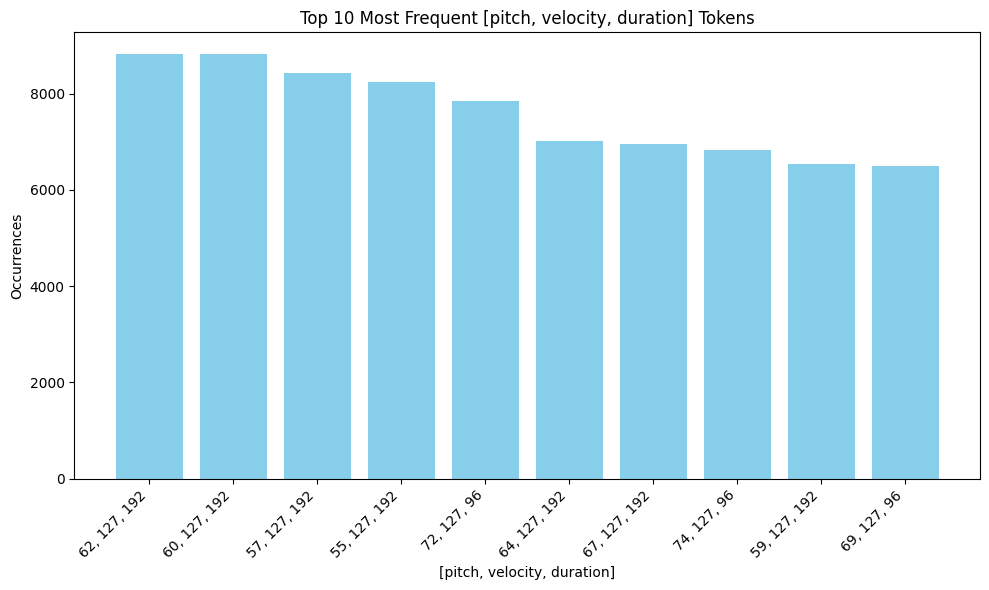

In [9]:
flattened_ids = [token_id for seq in tokenized_sequences for token_id in seq]

# Count occurrences of each token ID
id_counts = Counter(flattened_ids)

# Get the 10 most common token IDs
top_id_counts = id_counts.most_common(10)
top_ids, counts = zip(*top_id_counts)

# Map each top ID back to its (pitch, velocity, duration) tuple
labels = [id_to_event[token_id] for token_id in top_ids]

# Convert each tuple to a string for display, e.g. "(60, 100, 96)"
label_strings = [f"{((pitches))}, {vel}, {dur}" for (pitches, vel, dur) in labels]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_ids)), counts, tick_label=label_strings, color='skyblue')
plt.xlabel('[pitch, velocity, duration]')
plt.ylabel('Occurrences')
plt.title('Top 10 Most Frequent [pitch, velocity, duration] Tokens')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

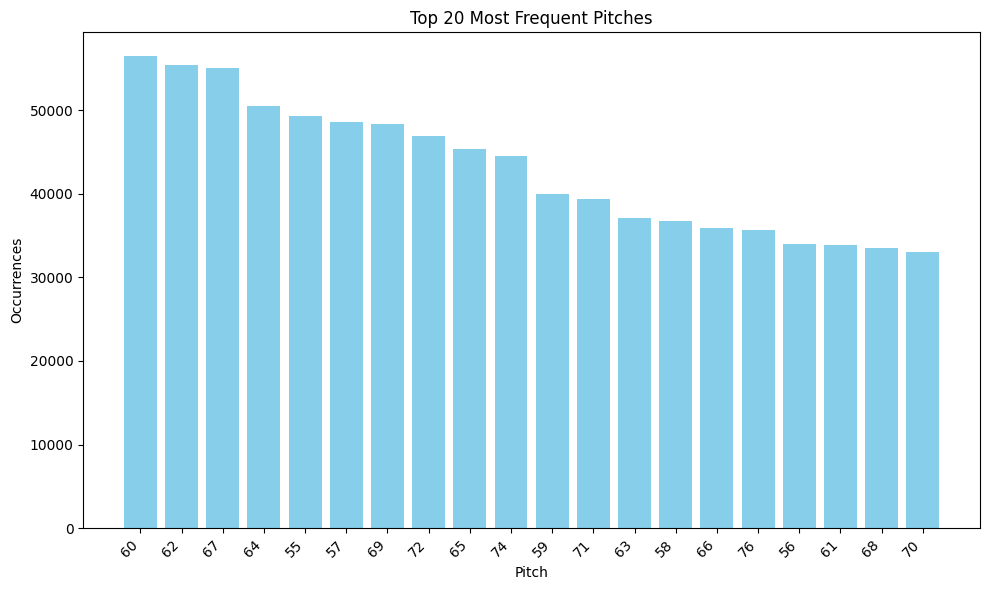

In [10]:
flattened_pitches = [p for seq in all_pitch_sequences for p in seq]
pitches_count = Counter(flattened_pitches)
top_pitches = pitches_count.most_common(20)
p, counts = zip(*top_pitches)

plt.figure(figsize=(10, 6))
plt.bar(range(len(p)), counts, tick_label=p, color='skyblue')
plt.xlabel('Pitch')
plt.ylabel('Occurrences')
plt.title('Top 20 Most Frequent Pitches')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Create Midi File Function

The `create_midi` function converts a sequence of musical events (represented by lists of pitches, durations, velocities, and optional channels) into a playable **MIDI file**.

- Creates a single MIDI track with a **default tempo of 120 BPM** and **4/4 time signature**.
- For each event:
  - Sends a `note_on` message at the current tick (time=0).
  - Sends a `note_off` message after a specified duration in ticks.
- **Velocity** (volume) and **channel** can be customized for each note, or default to 100 and 0 if not provided.
- Returns a `MidiFile` object that can be saved to disk or played in a DAW.


In [11]:
def create_midi(pitches, durations, velocities=None, channels=None, ticks_per_beat=96):
    mid = MidiFile(ticks_per_beat=ticks_per_beat)
    track = MidiTrack()
    mid.tracks.append(track)

    # Add metadata (tempo, time signature)
    track.append(MetaMessage('set_tempo', tempo=500000, time=0))  # 120 BPM
    track.append(MetaMessage('time_signature', numerator=4, denominator=4, time=0))

    # Iterate through events
    for i, pitch in enumerate(pitches):
        dur = durations[i]
        vel = velocities[i] if velocities else 100
        chan = channels[i] if channels else 0

        # Note on at time=0
        track.append(Message('note_on', note=pitch, velocity=vel, channel=chan, time=0))
        # Note off after 'dur' ticks
        track.append(Message('note_off', note=pitch, velocity=0, channel=chan, time=dur))

    # End of track
    track.append(MetaMessage('end_of_track', time=0))
    return mid

## Baseline Model: Second-Order Markov Chain

The **SecondOrderMarkovChain** class is a baseline generative model for symbolic music. It uses a **second-order Markov chain** to capture musical transitions. This provides a simple, interpretable baseline for **unconditioned symbolic music generation**. 

- Each hidden state is defined by a **pair of consecutive tokens** (bi-gram).  
- During training, the model counts how frequently each possible “next token” follows a given state pair.  
- These counts are normalized into probabilities, creating a model that learns **P(next token | previous two tokens)**.



In [12]:
class SecondOrderMarkovChain:
    def __init__(self):
        self.transitions = defaultdict(lambda: defaultdict(int))
        self.probabilities = defaultdict(lambda: defaultdict(float))

    def train(self, tokenized_sequences):
        for sequence in tokenized_sequences:
            for i in range(len(sequence) - 2):
                state1, state2 = sequence[i], sequence[i + 1]
                next_state = sequence[i + 2]
                self.transitions[(state1, state2)][next_state] += 1

        for (state1, state2), next_states in self.transitions.items():
            total = sum(next_states.values())
            for next_state, count in next_states.items():
                self.probabilities[(state1, state2)][next_state] = count / total

        return self.probabilities

    def generate(self, seed_sequence, num_predictions=1):
        results = [seed_sequence[0], seed_sequence[1]]
        for _ in range(100):  # adjust as needed
            current_state = (results[-2], results[-1])
            if current_state not in self.probabilities:
                break
            probs = self.probabilities[current_state]
            states = list(probs.keys())
            probabilities = list(probs.values())
            if not states:
                break
            next_token = np.random.choice(states, p=probabilities)
            results.append(next_token)
        return results


In [13]:
markov_chain_model = SecondOrderMarkovChain()
markov_chain_model.train(tokenized_sequences)

mc_seed_sequence = random.choice(tokenized_sequences)
mc_generated_tokens = markov_chain_model.generate(mc_seed_sequence, num_predictions=1)
mc_generated_events = [id_to_event[token_id] for token_id in mc_generated_tokens]

mc_pitches = [int(e[0]) for e in mc_generated_events]
mc_velocities = [int(e[1]) for e in mc_generated_events]
mc_durations = [int(e[2]) for e in mc_generated_events]

mc_midi = create_midi(pitches=mc_pitches, velocities=mc_velocities, durations=mc_durations)
mc_midi.save('../output/markov_output.mid')

In [14]:
correct = 0
total = 0

for sequence in tokenized_sequences:  # or a separate validation set
    for i in range(len(sequence) - 2):
        state1, state2 = sequence[i], sequence[i+1]
        actual_next = sequence[i+2]
        current_state = (state1, state2)
        if current_state in markov_chain_model.probabilities:
            # Get the most probable next token
            next_tokens = markov_chain_model.probabilities[current_state]
            predicted_next = max(next_tokens, key=next_tokens.get)  # Most probable
            if predicted_next == actual_next:
                correct += 1
            total += 1

accuracy = correct / total if total > 0 else 0
print(f"Markov Chain Accuracy: {accuracy:.4f}")

Markov Chain Accuracy: 0.6968


## Hidden Markov Chains

This implementation of a **Hidden Markov Model (HMM)** is equivalent to a second-order Markov chain, but framed in the HMM context where the **hidden states** are pairs of consecutive tokens (bi-grams).

- Each hidden state is defined as a **pair of tokens**: `(t[i], t[i+1])`.  
- Transitions occur between these bi-grams, e.g., from `(t[i], t[i+1])` to `(t[i+1], t[i+2])`.  
- The emissions are **deterministic**: the second token of the hidden state is always emitted.

This HMM-based model provides a baseline for **symbolic music generation** that captures short-term dependencies (bi-gram transitions) in musical sequences. It typically produces more coherent and musically plausible transitions compared to simpler first-order models, while remaining efficient and easy to interpret.


In [15]:
class HiddenMarkovModel:
    """
    A Hidden Markov Model equivalent to a second-order Markov chain,
    where each hidden state is the last two observed tokens (a bigram).
    Emissions are deterministic: hidden state (t[i], t[i+1]) always “emits” t[i+1].
    """

    def __init__(self):
        # Counts for transitions between hidden states
        # Each hidden state is a tuple (prev_token, cur_token)
        self.hidden_transitions = defaultdict(lambda: defaultdict(int))
        # Transition probabilities: P(next_hidden_state | current_hidden_state)
        self.A = defaultdict(lambda: defaultdict(float))
        # Keep track of all hidden states seen during training
        self.hidden_states = set()

    def train(self, tokenized_sequences):
        """
        Build transition counts from hidden_state = (t[i], t[i+1])
        to next_hidden_state = (t[i+1], t[i+2]).
        
        tokenized_sequences: a list of lists of token IDs, e.g.
            [
                [12, 5, 33, 12, 8, ...],
                [7, 9, 3,  3, 14, ...],
                ...
            ]
        """
        for seq in tokenized_sequences:
            if len(seq) < 3:
                continue
            for i in range(len(seq) - 2):
                prev_token = seq[i]
                cur_token = seq[i + 1]
                next_token = seq[i + 2]

                current_hidden = (prev_token, cur_token)
                next_hidden = (cur_token, next_token)

                self.hidden_transitions[current_hidden][next_hidden] += 1
                self.hidden_states.add(current_hidden)
                self.hidden_states.add(next_hidden)

        # Normalize counts into probabilities
        for current_hidden, next_dict in self.hidden_transitions.items():
            total_count = sum(next_dict.values())
            for next_hidden, cnt in next_dict.items():
                self.A[current_hidden][next_hidden] = cnt / total_count

        return self.A

    def generate(self, seed_sequence, length=100):
        """
        Given a seed_sequence of length >= 2 (list of token IDs),
        produce a generated sequence of token IDs of length = len(seed_sequence) + length.
        
        seed_sequence: e.g. [t0, t1]
        length: how many additional tokens to sample
        """
        if len(seed_sequence) < 2:
            raise ValueError("seed_sequence must contain at least two tokens.")

        # Start results with the first two tokens
        results = [seed_sequence[0], seed_sequence[1]]
        current_hidden = (seed_sequence[0], seed_sequence[1])

        for _ in range(length):
            # If this hidden state wasn’t seen in training, we must stop
            if current_hidden not in self.A:
                break

            next_hidden_states = list(self.A[current_hidden].keys())
            probs = list(self.A[current_hidden].values())
            if not next_hidden_states:
                break

            # Sample next hidden state according to P(next_hidden | current_hidden)
            idx = np.random.choice(len(next_hidden_states), p=probs)
            next_hidden = next_hidden_states[idx]

            # next_hidden is (token_t, token_{t+1}); we emit token_{t+1}
            next_token = next_hidden[1]
            results.append(next_token)

            current_hidden = next_hidden

        return results



In [16]:
# 1. Instantiate and train on your tokenized_sequences (list of token-ID lists)
hmm_model = HiddenMarkovModel()
hmm_model.train(tokenized_sequences)  # tokenized_sequences should already be defined

# 2. Pick a random seed sequence (must be at least two tokens)
hmm_seed_sequence = random.choice(tokenized_sequences)

# 3. Generate a new sequence of token IDs (length = len(seed) + 100 by default)
generated_token_ids = hmm_model.generate(hmm_seed_sequence, length=100)

# 4. Map each token ID back to its actual event tuple (pitch, velocity, duration)
generated_events = [id_to_event[token_id] for token_id in generated_token_ids]

pitches    = [e[0] for e in generated_events]
velocities = [e[1] for e in generated_events]
durations  = [e[2] for e in generated_events]

# 6. Create and save the MIDI file
hmm_midi = create_midi(pitches=pitches, velocities=velocities, durations=durations)
hmm_midi.save('../output/hmm_output.mid')


In [17]:
def evaluate_markov_accuracy(model, tokenized_sequences):
    correct = 0
    total = 0

    for seq in tokenized_sequences:
        if len(seq) < 3:
            continue
        for i in range(len(seq) - 2):
            prev_token = seq[i]
            cur_token = seq[i + 1]
            actual_next_token = seq[i + 2]

            current_hidden = (prev_token, cur_token)

            # Check if this state was seen in training
            if current_hidden not in model.A:
                continue

            next_states_probs = model.A[current_hidden]
            # Find the most probable next hidden state
            if not next_states_probs:
                continue

            # Most probable next hidden state
            next_hidden = max(next_states_probs, key=next_states_probs.get)
            predicted_next_token = next_hidden[1]  # emit the second token in hidden state

            if predicted_next_token == actual_next_token:
                correct += 1
            total += 1

    accuracy = correct / total if total > 0 else 0.0
    return accuracy

acc = evaluate_markov_accuracy(hmm_model, tokenized_sequences)
print(f"HMM-based bigram model accuracy: {acc:.4f}")

HMM-based bigram model accuracy: 0.6968


## N-gram

The **N-gram Model** is a flexible generative model for symbolic music that learns transition probabilities for variable-length contexts of musical events.

- The model constructs **N-grams** from the training data:
  - A context of the previous **(n-1)** tokens
  - The next token to be predicted
- By counting how often each token follows each context, it estimates **P(next token | context)**.

This N-gram model can flexibly capture local patterns of notes or rhythms in symbolic music.

In [18]:
class NGramModel:
    def __init__(self, n=3):
        """
        Initialize an N-gram model.
        :param n: Order of the N-gram (e.g., 2 for bigram, 3 for trigram)
        """
        self.n = n
        self.ngram_counts = defaultdict(lambda: defaultdict(int))
        self.probabilities = defaultdict(lambda: defaultdict(float))
        self.contexts = set()

    def train(self, tokenized_sequences):
        """
        Build the transition probabilities from N-grams.
        :param tokenized_sequences: List of lists of token IDs
        """
        for seq in tokenized_sequences:
            if len(seq) < self.n:
                continue
            for i in range(len(seq) - self.n + 1):
                context = tuple(seq[i:i + self.n - 1])
                next_token = seq[i + self.n - 1]

                self.ngram_counts[context][next_token] += 1
                self.contexts.add(context)

        # Normalize counts to probabilities
        for context, next_tokens in self.ngram_counts.items():
            total_count = sum(next_tokens.values())
            for next_token, count in next_tokens.items():
                self.probabilities[context][next_token] = count / total_count

    def generate(self, seed_sequence, length=100):
        """
        Generate a new sequence starting from a seed.
        :param seed_sequence: List of at least (n-1) token IDs
        :param length: Number of additional tokens to generate
        :return: Generated sequence as a list of token IDs
        """
        if len(seed_sequence) < self.n - 1:
            raise ValueError(f"Seed sequence must be at least {self.n - 1} tokens long.")
        
        results = seed_sequence.copy()

        for _ in range(length):
            context = tuple(results[-(self.n - 1):])
            if context not in self.probabilities:
                break  # stop if context not seen in training

            next_tokens = list(self.probabilities[context].keys())
            probs = list(self.probabilities[context].values())
            if not next_tokens:
                break

            next_token = random.choices(next_tokens, weights=probs)[0]
            results.append(next_token)

        return results

    def evaluate_accuracy(self, tokenized_sequences):
        """
        Evaluate next-token prediction accuracy.
        :param tokenized_sequences: List of lists of token IDs
        :return: Accuracy as float
        """
        correct = 0
        total = 0

        for seq in tokenized_sequences:
            if len(seq) < self.n:
                continue
            for i in range(len(seq) - self.n):
                context = tuple(seq[i:i + self.n - 1])
                actual_next = seq[i + self.n - 1]

                if context not in self.probabilities:
                    continue

                next_tokens_probs = self.probabilities[context]
                if not next_tokens_probs:
                    continue

                predicted_next = max(next_tokens_probs, key=next_tokens_probs.get)
                if predicted_next == actual_next:
                    correct += 1
                total += 1

        return correct / total if total > 0 else 0.0

In [19]:
ngram_model = NGramModel(n=3)
ngram_model.train(tokenized_sequences)

ngram_seed_sequence = random.choice(tokenized_sequences)[:2]  # for trigram, seed is length 2
generated_token_ids = ngram_model.generate(ngram_seed_sequence, length=100)

generated_events = [id_to_event[token_id] for token_id in generated_token_ids]
ngram_pitches = [e[0] for e in generated_events]
ngram_velocities = [e[1] for e in generated_events]
ngram_durations = [e[2] for e in generated_events]

midi = create_midi(ngram_pitches, ngram_durations, ngram_velocities)
midi.save("../output/ngram_output.mid")
print("Generated MIDI file saved as output/ngram_output.mid!")

acc = ngram_model.evaluate_accuracy(tokenized_sequences)
print(f"N-gram model accuracy: {acc:.4f}")

Generated MIDI file saved as output/ngram_output.mid!
N-gram model accuracy: 0.6968


## Hidden Markov Chain For Polyphonic

In this section, we implemented a **Hidden Markov Model (HMM)** for generating polyphonic music. Unlike monophonic models that focus on individual notes, this approach models transitions between **chord events**, where each event is a simultaneous group of pitches.

### 🧩 Data Representation
- **Chord Event**: `(frozenset_of_pitches, velocity, duration)`  
- We treat each unique chord event as a **token** in our vocabulary, just like single notes.

### 🏗️ Model Structure
- Each **hidden state** in the HMM is a **bi-gram of chord events**: `(chord_id_{t-1}, chord_id_t)`.  
- Transitions are counted and normalized to probabilities, capturing how likely one chord moves to another.

This polyphonic HMM allows us to explore richer musical textures by treating chords as basic building blocks, producing output that mixes melodic movement with harmonic context.

In [20]:
def extract_poly_chords(midi_path):
    """
    Parse a MIDI file into a list of chord‐events, where each chord event is
    a tuple (frozenset_of_pitches, velocity, duration_in_ticks).
    Any file that raises KeySignatureError is skipped.
    """
    try:
        mid = MidiFile(midi_path)
        # Step 1: collect all note_on and note_off with absolute times
        abs_time = 0
        note_starts = {}              # pitch → (start_tick, velocity)
        on_events_by_tick = defaultdict(list)
        off_events_by_pitch = {}      # pitch → end tick

        for track in mid.tracks:
            abs_time = 0
            for msg in track:
                abs_time += msg.time
                if msg.type == 'note_on' and msg.velocity > 0:
                    # record start time + velocity
                    note_starts[msg.note] = (abs_time, msg.velocity)
                    on_events_by_tick[abs_time].append(msg.note)

                elif msg.type == 'note_off' or (msg.type == 'note_on' and msg.velocity == 0):
                    if msg.note in note_starts:
                        start_tick, vel = note_starts.pop(msg.note)
                        off_events_by_pitch[msg.note] = abs_time

        # Step 2: build chord events: group notes that started at the same tick
        chord_seq = []
        for tick, pitches in sorted(on_events_by_tick.items()):
            chord_pitches = frozenset(pitches)

            # Determine a “representative” velocity (take max of the velocities for these pitches)
            vel_values = []
            durations = []
            for p in pitches:
                # Velocity was recorded when the note started; retrieve it:
                if p in note_starts:
                    # (In some rare cases, note_starts may have been popped already,
                    # so fallback to a default 64 if missing.)
                    _, v = note_starts[p]
                else:
                    v = 100
                vel_values.append(v)

                # Compute duration = end_tick – start_tick if we have both
                if p in off_events_by_pitch:
                    end_tick = off_events_by_pitch[p]
                    durations.append(end_tick - tick)

            if not vel_values:
                chord_vel = 100
            else:
                chord_vel = max(vel_values)

            if not durations:
                chord_dur = mid.ticks_per_beat
            else:
                chord_dur = max(0, min(durations))

            chord_seq.append((chord_pitches, chord_vel, chord_dur))
    except:
        # Skip this file entirely if its key signature is invalid
        return []

    return chord_seq


In [21]:
all_chord_events = []
for midi_file in midi_files_path_list:
    chord_seq = extract_poly_chords(midi_file)
    if not chord_seq:
        # either the file was too short (<3 notes) or it raised KeySignatureError
        continue
    all_chord_events.extend(chord_seq)

unique_events = list(dict.fromkeys(all_chord_events))  # deduplicate, preserve order
event_to_id = {evt: i for i, evt in enumerate(unique_events)}
id_to_event = {i: evt for evt, i in event_to_id.items()}

In [22]:
tokenized_sequences = []
for midi_file in midi_files_path_list:
    chord_seq = extract_poly_chords(midi_file)          # [(frozenset,…), …]
    chord_ids = [event_to_id[ch] for ch in chord_seq]
    tokenized_sequences.append(chord_ids)

In [23]:
import numpy as np
import random
from collections import defaultdict
from mido import MidiFile, MidiTrack, Message, MetaMessage

# ---------------------------------------------------
# 1) HMM class for polyphonic “chord‐event” tokens
# ---------------------------------------------------
class HiddenMarkovModelPoly:
    """
    Hidden Markov Model where each “hidden state” is a bigram of chord‐IDs:
       hidden_t = ( chord_id_{t-1},  chord_id_t )
    Emission is deterministic: hidden=(a,b) → emit b (a chord ID).
    
    Chord event format = (frozenset_of_pitches, velocity, duration).
    You must supply two mappings externally:
        event_to_id: { (frozenset, vel, dur) → unique_int }
        id_to_event: { unique_int → (frozenset, vel, dur) }
    """

    def __init__(self):
        # Counts[(prev_id, cur_id)][(cur_id, next_id)] = integer count
        self.hidden_transitions = defaultdict(lambda: defaultdict(int))
        # Probabilities[(a,b)][(b,c)] = P((b,c) | (a,b))
        self.A = defaultdict(lambda: defaultdict(float))
        # Keep track of which bigram‐states exist
        self.hidden_states = set()

    def train(self, tokenized_sequences):
        """
        tokenized_sequences: list of lists of chord‐IDs, e.g.
            [
              [  12,   37,   12, … ],
              [   8,   12,   40, … ],
              …
            ]
        Each integer represents one “(frozenset_of_pitches, vel, dur)” chord event.
        
        We count transitions:
          (c[i], c[i+1]) → (c[i+1], c[i+2])
        """
        for seq in tokenized_sequences:
            if len(seq) < 3:
                continue
            for i in range(len(seq) - 2):
                prev_id = seq[i]
                cur_id  = seq[i + 1]
                nxt_id  = seq[i + 2]

                current_hidden = (prev_id, cur_id)
                next_hidden    = (cur_id, nxt_id)

                self.hidden_transitions[current_hidden][next_hidden] += 1
                self.hidden_states.add(current_hidden)
                self.hidden_states.add(next_hidden)

        # Normalize counts → probabilities
        for current_hidden, next_dict in self.hidden_transitions.items():
            total = sum(next_dict.values())
            for next_hidden, cnt in next_dict.items():
                self.A[current_hidden][next_hidden] = cnt / total

        return self.A

    def generate(self, seed_sequence, length=100):
        """
        seed_sequence: a list of ≥2 chord‐IDs, e.g. [c0, c1].
        length: how many additional chord‐IDs to sample on top of the seed.
        
        Returns a list of chord‐IDs of total length = len(seed_sequence) + length.
        """
        if len(seed_sequence) < 2:
            raise ValueError("seed_sequence must have at least two chord IDs.")

        results = [seed_sequence[0], seed_sequence[1]]
        current_hidden = (seed_sequence[0], seed_sequence[1])

        for _ in range(length):
            if current_hidden not in self.A:
                # no outgoing transitions: stop early
                break

            next_hidden_states = list(self.A[current_hidden].keys())
            probs = list(self.A[current_hidden].values())
            if not next_hidden_states:
                break

            idx = np.random.choice(len(next_hidden_states), p=probs)
            next_hidden = next_hidden_states[idx]
            # next_hidden is (cur_id, nxt_id)
            next_chord_id = next_hidden[1]

            results.append(next_chord_id)
            current_hidden = next_hidden

        return results

# ---------------------------------------------------
# 2) Example “driver” code, assuming you've built these maps:
#
#       event_to_id   : dict[(frozenset, vel, dur) → int]
#       id_to_event   : dict[int → (frozenset, vel, dur)]
#
#    And tokenized_sequences is a list of lists of chord‐IDs.
# ---------------------------------------------------

# (A) instantiate & train:
hmm_poly = HiddenMarkovModelPoly()
hmm_poly.train(tokenized_sequences)  
# where tokenized_sequences is [[id1, id2, …], [ … ], …]

# (B) pick a random seed (must be at least two chord‐IDs):
seed_sequence = random.choice(tokenized_sequences)  # e.g. [c123, c45, c78, …]

# (C) generate a new chord‐ID sequence (e.g. 100 extra chords):
generated_ids = hmm_poly.generate(seed_sequence, length=100)

# (D) convert chord‐IDs back into chord‐events (frozenset_of_pitches, vel, dur):
generated_events = [id_to_event[ch_id] for ch_id in generated_ids]

# (E) split into three parallel lists (for the MIDI writer):
#     - pitches_list:   a list of frozensets of ints
#     - velocities:     a list of ints
#     - durations:      a list of ints
pitches_list = [evt[0] for evt in generated_events]
velocities   = [evt[1] for evt in generated_events]
durations    = [evt[2] for evt in generated_events]

# ---------------------------------------------------
# 3) Polyphonic create_midi: write each chord as simultaneous note_on/note_off
# ---------------------------------------------------
from mido import MidiFile, MidiTrack, Message, MetaMessage

def create_midi_poly(pitches_list, durations, velocities=None, channels=None, ticks_per_beat=96):
    """
    pitches_list[i]  = either:
                         • an int (single pitch)
                         • an iterable (e.g. frozenset or list) of ints (polyphonic chord)
    durations[i]     = integer tick-length
    velocities[i]    = integer velocity for all notes in that chord (default=100 if None)
    channels[i]      = integer 0–15 MIDI channel (default=0 if None)
    """
    mid = MidiFile(ticks_per_beat=ticks_per_beat)
    track = MidiTrack()
    mid.tracks.append(track)

    # Add tempo & time signature at the start
    track.append(MetaMessage('set_tempo',    tempo=500000, time=0))  # 120 BPM
    track.append(MetaMessage('time_signature', numerator=4, denominator=4, time=0))

    for i, chord_pitches in enumerate(pitches_list):
        dur = durations[i]
        if dur > 200:
            dur /= 750
        dur = int(dur)
        vel = velocities[i] if velocities else 100
        chan = channels[i] if channels else 0

        # If chord_pitches is an int, make it a single-item set
        if isinstance(chord_pitches, int):
            chord = {chord_pitches}
        else:
            chord = set(chord_pitches)

        # 1) Send a batch of note_on messages so they all start together
        first = True
        for pitch in chord:
            if first:
                track.append(Message('note_on', note=pitch, velocity=vel, channel=chan, time=0))
                first = False
            else:
                track.append(Message('note_on', note=pitch, velocity=vel, channel=chan, time=0))

        # 2) After 'dur' ticks, send a batch of note_off messages together
        #    We send note_off for one pitch with time=dur, then time=0 for the others.
        iterator = iter(chord)
        first_pitch = next(iterator)
        track.append(Message('note_off', note=first_pitch, velocity=0, channel=chan, time=dur))
        for pitch in iterator:
            track.append(Message('note_off', note=pitch, velocity=0, channel=chan, time=0))

    # End of track
    track.append(MetaMessage('end_of_track', time=0))
    return mid

# (F) Write out the MIDI:
hmm_poly_midi = create_midi_poly(
    pitches_list=pitches_list,
    durations=durations,
    velocities=velocities,
    channels=None,
    ticks_per_beat=96
)
hmm_poly_midi.save('../output/hmm_poly_output.mid')


## Log Likelihood

To evaulate the quality of the generated music, we use **log-likelihood** metric. Log-likelihood measures how likely it is that a model would generate a given sequence of events (notes, chords, etc.).

- **Higher log-likelihood (closer to 0)** → transitions in the sequence are more consistent with the model’s training data (more likely transitions).  
- **Lower log-likelihood (more negative)** → transitions are less familiar to the model (less likely or novel transitions).

In [24]:
def compute_hmm_log_likelihood(model, sequence):
    """
    Compute the average log-likelihood of a chord-ID sequence under the given model.
    
    Args:
        model: Your trained HiddenMarkovModelPoly instance.
        sequence: A list of chord IDs (e.g. [12, 34, 56, ...])
    
    Returns:
        avg_log_likelihood: The average log-likelihood per transition (float).
        total_log_likelihood: The total log-likelihood (float).
    """
    log_likelihood = 0.0
    count = 0

    for i in range(len(sequence) - 2):
        prev_id = sequence[i]
        cur_id = sequence[i + 1]
        nxt_id = sequence[i + 2]

        current_hidden = (prev_id, cur_id)
        next_hidden = (cur_id, nxt_id)

        # Probability of next_hidden given current_hidden
        prob = model.A.get(current_hidden, {}).get(next_hidden, 1e-8)  # avoid log(0)

        log_likelihood += np.log(prob)
        count += 1

    avg_log_likelihood = log_likelihood / count if count > 0 else float('-inf')
    return avg_log_likelihood, log_likelihood


In [25]:
def compute_markov_log_likelihood(model, sequence):
    log_likelihood = 0.0
    count = 0
    for i in range(len(sequence) - 2):
        state = (sequence[i], sequence[i+1])
        next_token = sequence[i+2]
        prob = model.probabilities.get(state, {}).get(next_token, 1e-8)
        log_likelihood += np.log(prob)
        count += 1
    avg_ll = log_likelihood / count if count > 0 else float('-inf')
    return avg_ll, log_likelihood


In [26]:
def compute_ngram_log_likelihood(model, sequence):
    """
    Compute the average log-likelihood of a sequence under an N-gram model.
    
    Args:
        model: your trained NGramModel instance.
        sequence: list of token IDs to evaluate.
    
    Returns:
        avg_log_likelihood: float, average log-likelihood per prediction.
        total_log_likelihood: float, total log-likelihood.
    """
    n = model.n
    log_likelihood = 0.0
    count = 0

    for i in range(len(sequence) - n + 1):
        context = tuple(sequence[i:i + n - 1])
        next_token = sequence[i + n - 1]

        prob = model.probabilities.get(context, {}).get(next_token, 1e-8)  # default small prob
        log_likelihood += np.log(prob)
        count += 1

    avg_log_likelihood = log_likelihood / count if count > 0 else float('-inf')
    return avg_log_likelihood, log_likelihood


In [27]:
# Compute log-likelihood
sequence_to_check = mc_seed_sequence
avg_ll, total_ll = compute_markov_log_likelihood(markov_chain_model, sequence_to_check)

print("Average log-likelihood:", avg_ll)
print("Total log-likelihood:", total_ll)

Average log-likelihood: -0.48204364521441745
Total log-likelihood: -107.97777652802951


Log Likelihood for N-gram Model

In [28]:
# Compute log-likelihood
sequence_to_check = ngram_seed_sequence
avg_ll, total_ll = compute_ngram_log_likelihood(ngram_model, sequence_to_check)

print("Average log-likelihood:", avg_ll)
print("Total log-likelihood:", total_ll)


Average log-likelihood: -inf
Total log-likelihood: 0.0


In [29]:
# 1. Choose a sequence to evaluate (can be generated OR real from training data)
sequence_to_check = hmm_seed_sequence  # or any other chord-ID sequence

# 2. Compute log-likelihood
avg_ll, total_ll = compute_hmm_log_likelihood(hmm_model, sequence_to_check)

print(f"Average log-likelihood per transition: {avg_ll}")
print(f"Total log-likelihood: {total_ll}")


Average log-likelihood per transition: -0.18380953157255825
Total log-likelihood: -77.20000326047446


In [30]:
# 1. Choose a sequence to evaluate (can be generated OR real from training data)
sequence_to_check = generated_ids  # or any other chord-ID sequence

# 2. Compute log-likelihood
avg_ll, total_ll = compute_hmm_log_likelihood(hmm_poly, sequence_to_check)

print(f"Average log-likelihood per transition: {avg_ll}")
print(f"Total log-likelihood: {total_ll}")


Average log-likelihood per transition: 0.0
Total log-likelihood: 0.0
